In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from itertools import product
from scipy.stats import truncnorm

from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

In [3]:
path = '/tmp/tensorflow/mnist/input_data'
mnist = input_data.read_data_sets(path, one_hot=True)

Extracting /tmp/tensorflow/mnist/input_data/train-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/train-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-labels-idx1-ubyte.gz


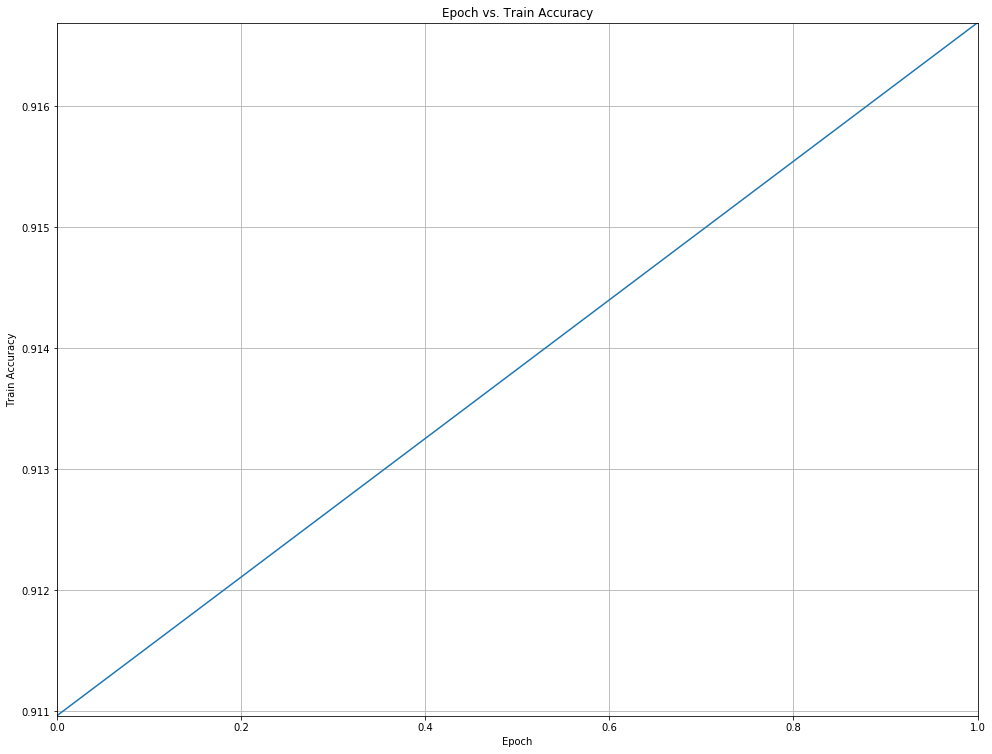

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

train_df = pd.read_csv("part1/train_accuracy.csv")
x_label, y_label = train_df.columns

with PdfPages("part1/train_accuracy.pdf") as pdf:
    fig, ax = plt.subplots()
    fig.set_size_inches(1.5 * 11, 1.5 * 8.5)
    ax.grid()
    ax.set_title(x_label + " vs. " + y_label)
    ax.set_xlabel(x_label)
    ax.set_xlim((train_df[x_label].min(), train_df[x_label].max()))
    ax.set_ylabel(y_label)
    ax.set_ylim((train_df[y_label].min(), train_df[y_label].max()))
    ax.plot(train_df[x_label], train_df[y_label])
    pdf.savefig(fig)
    plt.show()

In [34]:
train_df.columns

Index(['Epoch', 'Train Accuracy'], dtype='object')

In [4]:
class NN:
    class Utils:
        def pad(x, ksize, strides, padding='SAME'):
            batch_size, in_height, in_width, in_channels = x.shape
            k_batch_size, k_height, k_width, k_channels = ksize
            if padding == 'SAME':
                out_height = ceil(float(in_height) / float(strides[1]))
                out_width = ceil(float(in_width) / float(strides[2]))
                if (in_height % strides[1] == 0):
                    pad_height = max(k_height - strides[1], 0)
                else:
                    pad_height = max(k_height - (in_height % strides[1]), 0)
                if (in_width % strides[2] == 0):
                    pad_width = max(k_width - strides[2], 0)
                else:
                    pad_width = max(k_width - (in_width % strides[2]), 0)
                pad_top = pad_height // 2
                pad_bottom = pad_height - pad_top
                pad_left = pad_width // 2
                pad_right = pad_width - pad_left
            elif padding == 'VALID':
                out_height = ceil(float(in_height - k_height + 1) / float(strides[1]))
                out_width = ceil(float(in_width - k_width + 1) / float(strides[2]))
                pad_top = 0
                pad_bottom = 0
                pad_left = 0
                pad_right = 0
            return pad_top, pad_bottom, pad_left, pad_right, out_height, out_width
        
        def img_to_col(x, out_height, out_width, filter_height, filter_width, strides):
            batch_size = x.shape[0]
            in_channels = x.shape[3]
            x_col = np.zeros((batch_size * out_height * out_width, filter_height * filter_width * in_channels))
            for b in range(batch_size):
                for i in range(out_height):
                    for j in range(out_width):
                        row = b * out_height * out_width + i * out_width + j
                        for p in range(filter_height):
                            for q in range(filter_width):
                                for r in range(in_channels):
                                    col = p * filter_width * in_channels + q * in_channels + r
                                    x_col[row, col] += x[b, strides[1] * i + p, strides[2] * j + q, r]
            return x_col
        
        def col_to_img(x_col, out_height, out_width, in_height, in_width, filter_height, filter_width, strides):
            batch_size = x_col.shape[0] // (out_height * out_width)
            in_channels = x_col.shape[1] // (filter_height * filter_width)
            x = np.zeros((batch_size, in_height, in_width, in_channels))
            for b in range(batch_size):
                for i in range(out_height):
                    for j in range(out_width):
                        row = b * out_height * out_width + i * out_width + j
                        for p in range(filter_height):
                            for q in range(filter_width):
                                for r in range(in_channels):
                                    col = p * filter_width * in_channels + q * in_channels + r
                                    x[b, strides[1] * i + p, strides[2] * j + q, r] += x_col[row, col]
            return x
        
        
    class Variables:
        def weight_variable(shape):
            """
            Initialize weight matrices with truncated normal distribution with standard deviation of 0.1.

            In general, shape = [filter_height, filter_width, in_channels, out_channels].
            """
            stddev = 0.1
            size = 1
            for dim in shape:
                size *= dim
            return truncnorm.rvs(-2 * stddev, 2 * stddev, size=size).reshape(shape)

        def bias_variable(shape):
            """
            Initialize bias vectors with constant value of 0.1.

            In general, shape = [out_channels].
            """
            const = 0.1
            return np.full(shape, const)
    
    
    class Activations:
        class relu:
            def __init__(self, z):
                """Compute the rectified linear unit using z."""
                self.z = z
                self.mask_nonneg = (z >= 0).astype(np.float32)
                mask_zero = (z == 0).astype(np.float32)
                self.mask = self.mask_nonneg - 0.5 * mask_zero

            def out(self):
                self.out = self.z * self.mask
                return self.out

            def grad_z(self, grad_out):
                """Compute the derivative of the rectified linear unit using z."""
                self.grad_z = grad_out * self.mask
                return self.grad_z


        class softmax:
            def __init__(self, z):
                """Compute the softmax of z."""
                self.z = z
                self.e_z = np.exp(z - z.max())
                self.e_z_sum = self.e_z.reshape((self.e_z.shape[0], -1)).sum(axis = 1)

            def out(self):
                self.out = (self.e_z.T / self.e_z_sum).T
                return self.out
            
            def grad_z(self, grad_out):
                """Compute the derivative of the softmax of z."""
                self.grad_z = (grad_out * self.out) - grad_out.dot(np.outer(self.out, self.out))
                return self.grad_z
    
    
    class Layers:
        class flatten:
            def __init__(self, x):
                """Flatten tensor to shape [batch_size, x_height * x_width * in_channels]."""
                self.x = x

            def out(self):
                self.out_val = self.x.reshape((self.x.shape[0], -1))
                return self.out_val
            
            def grad_x(self, grad_out):
                self.grad_x_val = grad_out.reshape(self.x.shape)
                return self.grad_x_val
            
        
        class fullconn:
            def __init__(self, x, w):
                """Fully connected layer."""
                assert(x.shape[-1] == w.shape[0])
                self.x = x
                self.w = w
                self.batch_size = x.shape[0]
                self.in_channels = x.shape[1]
                self.out_channels = w.shape[1]

            def out(self):
                self.out_val = self.x.dot(self.w)
                return self.out_val

            def grad_x(self, grad_out):
                self.grad_x_val = grad_out.dot(self.w.T)
                return self.grad_x_val

            def grad_w(self, grad_out):
                self.grad_w_val = self.x.T.dot(grad_out)
                return self.grad_w_val
            
            
        class conv2d:
            def __init__(self, x, w, strides=[1, 1, 1, 1], padding='SAME'):
                assert(x.shape[3] == w.shape[2])
                self.x = x
                self.w = w
                self.strides = strides
                self.batch_size = x.shape[0]
                self.in_height = x.shape[1]
                self.in_width = x.shape[2]
                self.filter_height = w.shape[0]
                self.filter_width = w.shape[1]
                self.in_channels = w.shape[2]
                self.out_channels = w.shape[3]
                
                ksize = (1, self.filter_height, self.filter_width, 1)
                padding_out = NN.Utils.pad(x, ksize, strides, padding = padding)
                self.pad_top = padding_out[0]
                self.pad_bottom = padding_out[1]
                self.pad_left = padding_out[2]
                self.pad_right = padding_out[3]
                self.out_height = padding_out[4]
                self.out_width = padding_out[5]
                self.x_pad = np.pad(x, [(0, 0), (self.pad_top, self.pad_bottom), (self.pad_left, self.pad_right), (0, 0)], mode='constant')
            
            def out_bkp(self):
                self.out = np.empty((self.batch_size, self.out_height, self.out_width, self.out_channels))
                for b in range(self.batch_size):
                    for i in range(self.out_height):
                        for j in range(self.out_width):
                            for k in range(self.out_channels):
                                self.out[b, i, j, k] = (self.x_pad[b, (self.strides[1] * i):(self.strides[1] * i + self.filter_height), (self.strides[2] * j):(self.strides[2] * j + self.filter_width), :] * self.w[::-1, ::-1, :, k]).sum(axis = (0, 1))
                return self.out
            
            def out(self):
                x_col = NN.Utils.img_to_col(self.x_pad, self.out_height, self.out_width, self.filter_height, self.filter_width, self.strides)
                w_col = self.w[::-1, ::-1].reshape((-1, self.out_channels))
                self.fullconn = NN.Layers.fullconn(x_col, w_col)
                out_col = self.fullconn.out()
                self.out_val = out_col.reshape((self.batch_size, self.out_height, self.out_width, self.out_channels))
                return self.out_val
            
            def grad_x(self, grad_out):
                grad_out_reshaped = grad_out.reshape((-1, self.out_channels))
                grad_x_col = self.fullconn.grad_x(grad_out_reshaped)
                self.grad_x_val = NN.Utils.col_to_img(grad_x_col, self.out_height, self.out_width, self.x_pad.shape[1], self.x_pad.shape[2], self.filter_height, self.filter_width, self.strides)
                if self.pad_top > 0:
                    self.grad_x_val = self.grad_x_val[:, self.pad_top:, :, :]
                if self.pad_bottom > 0:
                    self.grad_x_val = self.grad_x_val[:, :-self.pad_bottom, :, :]
                if self.pad_left > 0:
                    self.grad_x_val = self.grad_x_val[:, :, self.pad_left:, :]
                if self.pad_right > 0:
                    self.grad_x_val = self.grad_x_val[:, :, :-self.pad_right, :]
                return self.grad_x_val

            def grad_w(self, grad_out):
                grad_out_reshaped = grad_out.reshape((self.batch_size * self.out_height * self.out_width, self.out_channels))
                grad_w_col = self.fullconn.grad_w(grad_out_reshaped)
                self.grad_w_val = grad_w_col.reshape(self.w.shape)
                return self.grad_w_val


        class maxpool2d:
            def __init__(self, x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'):
                self.x = x
                self.ksize = ksize
                self.strides = strides
                self.batch_size = x.shape[0]
                self.in_height = x.shape[1]
                self.in_width = x.shape[2]
                self.in_channels = x.shape[3]
                self.out_channels = self.in_channels
                padding_out = NN.Utils.pad(x, ksize, strides, padding = padding)
                self.pad_top = padding_out[0]
                self.pad_bottom = padding_out[1]
                self.pad_left = padding_out[2]
                self.pad_right = padding_out[3]
                self.out_height = padding_out[4]
                self.out_width = padding_out[5]
                self.x_pad = np.pad(x, [(0, 0), (self.pad_top, self.pad_bottom), (self.pad_left, self.pad_right), (0, 0)], mode='constant')

            def out_bkp(self):
                self.out_val = np.empty((self.batch_size, self.out_height, self.out_width, self.out_channels))
                self.pos = np.zeros((self.batch_size, self.out_height, self.out_width, self.out_channels, 4), dtype = int)
                for b in range(self.batch_size):
                    for i in range(self.out_height):
                        stride_i = self.strides[1] * i
                        for j in range(self.out_width):
                            stride_j = self.strides[2] * j
                            for k in range(self.out_channels):
                                x_block = self.x_pad[b, (self.strides[1] * i):(self.strides[1] * i + self.ksize[1]), (self.strides[2] * j):(self.strides[2] * j + self.ksize[2]), k]
                                max_val = x_block.max()
                                self.out_val[b, i, j, k] = max_val
                                max_inds = list(np.unravel_index(x_block.argmax(), x_block.shape))
                                self.pos[b, i, j, k] = np.array([b, self.strides[1] * i + max_inds[0], self.strides[2] * j + max_inds[1], k])
                return self.out_val
            
            def grad_x_bkp(self, grad_out):
                self.grad_x_val = np.zeros(self.x_pad.shape)
                for b in range(self.batch_size):
                    for i in range(self.out_height):
                        for j in range(self.out_width):
                            for k in range(self.out_channels):
                                self.grad_x_val[tuple(self.pos[b, i, j, k])] = grad_out[b, i, j, k]
                return self.grad_x_val
            
            def out(self):
                x_reshaped = self.x_pad.transpose((3, 0, 1, 2)).reshape((self.in_channels * self.batch_size, self.in_height, self.in_width, 1))
                x_col = NN.Utils.img_to_col(x_reshaped, self.out_height, self.out_width, self.ksize[1], self.ksize[2], self.strides)
                self.x_col_maxcols = x_col.argmax(axis = 1)
                out_reshaped = x_col[np.arange(x_col.shape[0]), self.x_col_maxcols]
                self.out_val = out_reshaped.reshape((self.in_channels, self.batch_size, self.out_height, self.out_width)).transpose((1, 2, 3, 0))
                return self.out_val
            
            def grad_x(self, grad_out):
                grad_x_col = np.zeros((self.in_channels * self.batch_size * self.out_height * self.out_width, self.ksize[1] * self.ksize[2]))
                grad_x_col[np.arange(grad_x_col.shape[0]), self.x_col_maxcols] = grad_out.transpose((3, 0, 1, 2)).flatten()
                grad_x_reshaped = NN.Utils.col_to_img(grad_x_col, self.out_height, self.out_width, self.x_pad.shape[1], self.x_pad.shape[2], self.ksize[1], self.ksize[2], self.strides)
                if self.pad_top > 0:
                    grad_x_reshaped = grad_x_reshaped[:, self.pad_top:, :, :]
                if self.pad_bottom > 0:
                    grad_x_reshaped = grad_x_reshaped[:, :-self.pad_bottom, :, :]
                if self.pad_left > 0:
                    grad_x_reshaped = grad_x_reshaped[:, :, self.pad_left:, :]
                if self.pad_right > 0:
                    grad_x_reshaped = grad_x_reshaped[:, :, :-self.pad_right, :]
                self.grad_x_val = grad_x_reshaped.reshape((self.in_channels, self.batch_size, self.in_height, self.in_width)).transpose((1, 2, 3, 0))
                return self.grad_x_val
    
    
    class Cost:
        class cross_entropy:
            def __init__(self, y_label, y_out):
                self.y_label = y_label
                self.y_out = y_out
            
            def out(self):
                self.out_val = -np.sum(self.y_label * np.log(self.y_out))
                return self.out_val
            
            def grad_x(self):
                self.grad_x_val = -self.y_label / self.y_out
                return self.grad_x_val

        class softmax_cross_entropy:
            def __init__(self, y_label, y_out):
                self.y_label = y_label
                self.y_out = y_out
            
            def out(self):
                softmax = NN.Activations.softmax(self.y_out)
                self.out_val = -np.sum(self.y_label * np.log(softmax.out()))
                return self.out_val
            
            def grad_z(self):
                self.grad_z_val = self.y_out - self.y_label
                return self.grad_z_val
    
    
    class Metrics:
        def accuracy(y_label, y_out):
            correct_prediction = np.equal(np.argmax(y_label, axis = 1), np.argmax(y_out, axis = 1))
            return correct_prediction.astype(np.float32).mean()

In [5]:
class Model:
    def __init__(self, train_set, x_image_shape=[28, 28]):
        self.started = False
        self.train_set = train_set
        self.epochs_completed = 0
        self.x_image_shape = x_image_shape
        self.w = []
        self.dw = []
        self.b = []
        self.db = []
        self.f = []
        self.s = []
        
    def eval(self, batch_x_images):
        # Layer 0 (2D convolution layer)
        filter_shape_0 = [5, 5]
        in_channels_0 = 1
        out_channels_0 = 32

        # Reshape input
        x_0 = np.reshape(batch_x_images, [batch_x_images.shape[0]] + list(self.x_image_shape) + [in_channels_0])

        if not self.started:
            self.w.append(NN.Variables.weight_variable(filter_shape_0 + [in_channels_0, out_channels_0]))
            self.dw.append(None)
            self.b.append(NN.Variables.bias_variable([out_channels_0]))
            self.db.append(None)
            self.f.append(None)
            self.s.append(None)

        self.f[0] = NN.Layers.conv2d(x_0, self.w[0])
        z_0 = self.f[0].out() + self.b[0]
        self.s[0] = NN.Activations.relu(z_0)

        y_0 = self.s[0].out()

        # Layer 1 (Max pool 2x2)
        in_channels_1 = out_channels_0
        out_channels_1 = in_channels_1
        
        if not self.started:
            self.w.append(None)
            self.dw.append(None)
            self.b.append(None)
            self.db.append(None)
            self.f.append(None)
            self.s.append(None)

        self.f[1] = NN.Layers.maxpool2d(y_0)

        x_1 = self.f[1].out()

        # Layer 2 (2D convolution layer)
        filter_shape_2 = [5, 5]
        in_channels_2 = out_channels_1
        out_channels_2 = 64

        if not self.started:
            self.w.append(NN.Variables.weight_variable(filter_shape_2 + [in_channels_2, out_channels_2]))
            self.dw.append(None)
            self.b.append(NN.Variables.bias_variable([out_channels_2]))
            self.db.append(None)
            self.f.append(None)
            self.s.append(None)

        self.f[2] = NN.Layers.conv2d(x_1, self.w[2])
        z_2 = self.f[2].out() + self.b[2]
        self.s[2] = NN.Activations.relu(z_2)

        x_2 = self.s[2].out()

        # Layer 3 (Max pool 2x2)
        in_channels_3 = out_channels_2
        out_channels_3 = in_channels_3
        
        if not self.started:
            self.w.append(None)
            self.dw.append(None)
            self.b.append(None)
            self.db.append(None)
            self.f.append(None)
            self.s.append(None)

        self.f[3] = NN.Layers.maxpool2d(x_2)

        x_3 = self.f[3].out()

        # Layer 4 (Flatten)
        in_channels_4 = out_channels_3
        out_channels_4 = in_channels_4
        
        if not self.started:
            self.w.append(None)
            self.dw.append(None)
            self.b.append(None)
            self.db.append(None)
            self.f.append(None)
            self.s.append(None)

        self.f[4] = NN.Layers.flatten(x_3)

        x_4 = self.f[4].out()

        # Layer 5 (Fully connected layer)
        in_channels_5 = x_4.shape[-1]
        out_channels_5 = 1024

        if not self.started:
            self.w.append(NN.Variables.weight_variable([in_channels_5, out_channels_5]))
            self.dw.append(None)
            self.b.append(NN.Variables.bias_variable([out_channels_5]))
            self.db.append(None)
            self.f.append(None)
            self.s.append(None)

        self.f[5] = NN.Layers.fullconn(x_4, self.w[5])
        z_5 = self.f[5].out() + self.b[5]
        self.s[5] = NN.Activations.relu(z_5)

        x_5 = self.s[5].out()

        # Layer 6 (Fully connected layer)
        in_channels_6 = out_channels_5
        out_channels_6 = 10

        if not self.started:
            self.w.append(NN.Variables.weight_variable([in_channels_6, out_channels_6]))
            self.dw.append(None)
            self.b.append(NN.Variables.bias_variable([out_channels_6]))
            self.db.append(None)
            self.f.append(None)
            self.s.append(None)

        self.f[6] = NN.Layers.fullconn(x_5, self.w[6])
        z_6 = self.f[6].out() + self.b[6]
        self.s[6] = NN.Activations.softmax(z_6)

        x_6 = self.s[6].out()
        
        self.batch_y_out = x_6

        self.started = True
        
        return self.batch_y_out
    
    def backpropagate(self, batch_y_labels, lr = 0.5):
        n_layers = len(self.dw)
        cost = NN.Cost.softmax_cross_entropy(batch_y_labels, self.batch_y_out)

        delta = -lr * cost.grad_z()
        if not self.dw[n_layers - 1] is None:
            self.db[n_layers - 1] = np.sum(delta, axis = tuple(range(delta.ndim - 1))) / self.batch_size
            self.b[n_layers - 1] += self.db[n_layers - 1]
            self.dw[n_layers - 1] = self.f[n_layers - 1].grad_w(delta) / self.batch_size
            self.w[n_layers - 1] += self.dw[n_layers - 1]
        
        for i in reversed(range(n_layers - 1)):
            if self.dw[i] is None:
                delta = self.f[i + 1].grad_x(delta)
            else:
                delta = self.s[i].grad_z(self.f[i + 1].grad_x(delta))
                self.db[i] = np.sum(delta, axis = tuple(range(delta.ndim - 1))) / self.batch_size
                self.b[i] += self.db[i]
                self.dw[i] = self.f[i].grad_w(delta) / self.batch_size
                self.w[i] += self.dw[i]
    
    def train(self, batch_size, epochs, lr = 0.5):
        batch_num = 1
        while self.epochs_completed < epochs:
            prev_nepoch = self.epochs_completed
            batch_x_images, batch_y_labels = self.train_set.next_batch(batch_size)
            if self.train_set.epochs_completed > prev_nepoch:
                batch_num = 1
            batch_y_out = self.eval(batch_x_images)
            self.backpropagate(batch_y_labels, lr = lr)
            if batch_num % 50 == 0:
                batch_accuracy = NN.Metrics.accuracy(batch_y_labels, batch_y_out)
                print("Epoch: {0}, Batch: {1}, Accuracy: {2:.4f}".format(self.epochs_completed + 1, batch_num, batch_accuracy))
            batch_num += 1

In [25]:
5 + np.array(range(16)).reshape((4,4)) ** 2

array([[  5,   6,   9,  14],
       [ 21,  30,  41,  54],
       [ 69,  86, 105, 126],
       [149, 174, 201, 230]])

In [22]:
cost = NN.Cost.softmax_cross_entropy(np.array(range(2)), np.array(range(2)))

In [24]:
vars(cost)

{'y_label': array([0, 1]), 'y_out': array([0, 1])}

In [13]:
b = a.sum(axis = 1, keepdims = True)
b

array([[ 6],
       [22],
       [38],
       [54]])

In [14]:
a / b

array([[ 0.        ,  0.16666667,  0.33333333,  0.5       ],
       [ 0.18181818,  0.22727273,  0.27272727,  0.31818182],
       [ 0.21052632,  0.23684211,  0.26315789,  0.28947368],
       [ 0.22222222,  0.24074074,  0.25925926,  0.27777778]])

In [18]:
(a.T / a.sum(axis = 1)).T

array([[ 0.        ,  0.16666667,  0.33333333,  0.5       ],
       [ 0.18181818,  0.22727273,  0.27272727,  0.31818182],
       [ 0.21052632,  0.23684211,  0.26315789,  0.28947368],
       [ 0.22222222,  0.24074074,  0.25925926,  0.27777778]])

In [430]:
model = Model()
model.train(50, 3)

KeyboardInterrupt: 

In [94]:
x = mnist.train.images[:3].reshape((3, 28, 28, -1))
w = NN.Variables.weight_variable([5, 5, 1, 2])

filter_height, filter_width, in_channels, out_channels = w.shape
ksize = [1, filter_height, filter_width, 1]
strides = [1, 1, 1, 1]
padding = 'SAME'
pad_top, pad_bottom, pad_left, pad_right, out_height, out_width = NN.Utils.pad(x, ksize, strides=strides, padding=padding)
x_pad = np.pad(x, [(0, 0), (pad_top, pad_bottom), (pad_left, pad_right), (0, 0)], mode='constant')

batch_size, in_height, in_width, in_channels = x_pad.shape

In [95]:
w_col = w[::-1, ::-1].reshape((-1, out_channels))

In [96]:
x_col = np.empty((batch_size * out_height * out_width, filter_height * filter_width * in_channels))
for b in range(batch_size):
    for i in range(out_height):
        for j in range(out_width):
            row = b * out_height * out_width + i * out_width + j
            for p in range(filter_height):
                for q in range(filter_width):
                    for r in range(in_channels):
                        col = p * filter_width * in_channels + q * in_channels + r
                        x_col[row, col] = x_pad[b, strides[1] * i + p, strides[2] * j + q, r]

In [97]:
out_col = x_col.dot(w_col)
out = out_col.reshape((batch_size, out_height, out_width, out_channels))

In [98]:
np.allclose(NN.Layers.conv2d(x, w).out_bkp(), out)

True

In [146]:
p = np.array(range(16)).reshape(2,2,2,2)
p

array([[[[ 0,  1],
         [ 2,  3]],

        [[ 4,  5],
         [ 6,  7]]],


       [[[ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15]]]])

In [149]:
p.reshape(-1,2).reshape(2,2,2,2)

array([[[[ 0,  1],
         [ 2,  3]],

        [[ 4,  5],
         [ 6,  7]]],


       [[[ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15]]]])

In [166]:
np.allclose(y, x1[0, :, :, 0])

True

In [163]:
y[6]

array([ 0.        ,  0.06827557,  0.16107271,  0.29367168,  0.30623545,
        0.34196589,  0.29389756,  0.33536968,  0.33536968,  0.31093111,
        0.24768577,  0.18809707,  0.25015544,  0.23430163,  0.24797584,
        0.32116464,  0.16368114, -0.0010536 , -0.02712594,  0.06638454,
        0.0089785 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

In [164]:
NN.Layers.conv2d(x[0], w).eval()[:, :, 0][6]

array([ 0.        ,  0.06827557,  0.16107272,  0.29367167,  0.30623546,
        0.34196588,  0.29389757,  0.33536968,  0.33536968,  0.31093112,
        0.24768578,  0.18809707,  0.25015545,  0.23430163,  0.24797584,
        0.32116464,  0.16368115, -0.0010536 , -0.02712595,  0.06638454,
        0.0089785 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ], dtype=float32)

In [119]:
ksize = [1, 2, 2, 1]
strides = [1, 2, 2, 1]
padding = 'SAME'
pad_top, pad_bottom, pad_left, pad_right, out_height, out_width = NN.Utils.pad(x, ksize, strides=strides, padding=padding)
x_pad = np.pad(x, [(0, 0), (pad_top, pad_bottom), (pad_left, pad_right), (0, 0)], mode='constant')

batch_size, in_height, in_width, in_channels = x_pad.shape

In [120]:
x_reshaped = x_pad.reshape((batch_size * in_channels, in_height, in_width, 1))
x_col = NN.Utils.img_to_col(x_reshaped, out_height, out_width, ksize[1], ksize[2], strides)

In [121]:
x_col_maxrows = x_col.argmax(axis = 1)
out_reshaped = x_col[np.arange(x_col.shape[0]), x_col_maxrows]
out = out_reshaped.reshape((batch_size, out_height, out_width, in_channels))

In [122]:
np.allclose(NN.Layers.maxpool2d(x).out_bkp(), out)

True

In [134]:
grad_x_col = np.zeros((batch_size * out_height * out_width, ksize[1] * ksize[2] * in_channels))
grad_x_col[np.arange(grad_x_col.shape[0]), x_col_maxrows] = out.flatten()
grad_x = NN.Utils.col_to_img(grad_x_col, out_height, out_width, in_height, in_width, ksize[1], ksize[2], strides)

In [135]:
grad_x.shape

(3, 28, 28, 1)

In [142]:
a = NN.Layers.maxpool2d(x)
b = NN.Layers.maxpool2d(x)
np.allclose(a.grad_x_bkp(a.out_bkp()), b.grad_x(b.out()))

True

In [374]:
x_image_shape = [28, 28]
batch_size = 50
lr = 0.1
started = False

In [419]:
batch_xs, batch_ys = mnist.train.next_batch(batch_size)

# Layer 0 (2D convolution layer)
filter_shape_0 = [5, 5]
in_channels_0 = 1
out_channels_0 = 32

# Reshape input
x_0 = np.reshape(batch_xs, [batch_size] + list(x_image_shape) + [in_channels_0])

if not started:
    w_0 = NN.Variables.weight_variable(filter_shape_0 + [in_channels_0, out_channels_0])
    b_0 = NN.Variables.bias_variable([out_channels_0])

f_0 = NN.Layers.conv2d(x_0, w_0)
z_0 = f_0.out() + b_0
s_0 = NN.Activations.relu(z_0)

y_0 = s_0.out()

# Layer 1 (Max pool 2x2)
in_channels_1 = out_channels_0
out_channels_1 = in_channels_1

f_1 = NN.Layers.maxpool2d(y_0)

x_1 = f_1.out()

# Layer 2 (2D convolution layer)
filter_shape_2 = [5, 5]
in_channels_2 = out_channels_1
out_channels_2 = 64

if not started:
    w_2 = NN.Variables.weight_variable(filter_shape_2 + [in_channels_2, out_channels_2])
    b_2 = NN.Variables.bias_variable([out_channels_2])

f_2 = NN.Layers.conv2d(x_1, w_2)
z_2 = f_2.out() + b_2
s_2 = NN.Activations.relu(z_2)

x_2 = s_2.out()

# Layer 3 (Max pool 2x2)
in_channels_3 = out_channels_2
out_channels_3 = in_channels_3

f_3 = NN.Layers.maxpool2d(x_2)

x_3 = f_3.out()

# Layer 4 (Flatten)
in_channels_4 = out_channels_3
out_channels_4 = in_channels_4

f_4 = NN.Layers.flatten(x_3)

x_4 = f_4.out()

# Layer 5 (Fully connected layer)
in_channels_5 = x_4.shape[-1]
out_channels_5 = 1024

if not started:
    w_5 = NN.Variables.weight_variable([in_channels_5, out_channels_5])
    b_5 = NN.Variables.bias_variable([out_channels_5])

f_5 = NN.Layers.fullconn(x_4, w_5)
z_5 = f_5.out() + b_5
s_5 = NN.Activations.relu(z_5)

x_5 = s_5.out()

# Layer 6 (Fully connected layer)
in_channels_6 = out_channels_5
out_channels_6 = 10

if not started:
    w_6 = NN.Variables.weight_variable([in_channels_6, out_channels_6])
    b_6 = NN.Variables.bias_variable([out_channels_6])

f_6 = NN.Layers.fullconn(x_5, w_6)
z_6 = f_6.out() + b_6
s_6 = NN.Activations.softmax(z_6)

x_6 = s_6.out()

started = True

In [420]:
NN.Metrics.accuracy(batch_ys, x_6)

0.06

In [421]:
cost = NN.Cost.softmax_cross_entropy(batch_ys, x_6)

delta_6 = -lr * cost.grad_z() # (dJ/dx)(dS/dz)
db_6 = np.sum(delta_6, axis = tuple(range(delta_6.ndim - 1))) / batch_size
dw_6 = f_6.grad_w(delta_6) / batch_size # (dD/dw)

delta_5 = s_5.grad_z(f_6.grad_x(delta_6)) # (dJ/dx)(dS/dz)(dD/dx)(dR/dz)
db_5 = np.sum(delta_5, axis = tuple(range(delta_5.ndim - 1))) / batch_size
dw_5 = f_5.grad_w(delta_5) / batch_size # (dD/dw)

delta_4 = f_5.grad_x(delta_5) # (dJ/dx)(dS/dz)(dD/dx)(dR/dz)(dD/dx)

delta_3 = f_4.grad_x(delta_4) # (dJ/dx)(dS/dz)(dD/dx)(dR/dz)(dD/dx)(dF/dx)

delta_2 = s_2.grad_z(f_3.grad_x(delta_3)) # (dJ/dx)(dS/dz)(dD/dx)(dR/dz)(dD/dx)(dF/dx)(dP/dx)(dR/dz)
db_2 = np.sum(delta_2, axis = tuple(range(delta_2.ndim - 1))) / batch_size
dw_2 = f_2.grad_w(delta_2) / batch_size # (dC/dw)

delta_1 = f_2.grad_x(delta_2) # (dJ/dx)(dS/dz)(dD/dx)(dR/dz)(dD/dx)(dF/dx)(dP/dx)(dR/dz)(dC/dx)

delta_0 = s_0.grad_z(f_1.grad_x(delta_1)) # (dJ/dx)(dS/dz)(dD/dx)(dR/dz)(dD/dx)(dF/dx)(dP/dx)(dR/dz)(dC/dx)(dP/dx)
db_0 = np.sum(delta_0, axis = tuple(range(delta_0.ndim - 1))) / batch_size
dw_0 = f_0.grad_w(delta_0) / batch_size # (dC/dw)

In [422]:
(dw_0.min(), dw_0.max())

(-0.08770085034859956, 0.03420900676259703)

In [418]:
b_6 += db_6
w_6 += dw_6

b_5 += db_5
w_5 += dw_5

b_2 += db_2
w_2 += dw_2

b_0 += db_0
w_0 += dw_0

In [368]:
# cost = NN.Cost.softmax_cross_entropy(batch_ys, x_6)

# delta_6 = -lr * cost.grad_z()
# b_6 += np.sum(delta_6, axis = tuple(range(delta_6.ndim - 1))) / batch_size
# w_6 += f_6.grad_w(delta_6) / batch_size

# delta_5 = s_5.grad_z(f_6.grad_x(delta_6))
# b_5 += np.sum(delta_5, axis = tuple(range(delta_5.ndim - 1))) / batch_size
# w_5 += f_5.grad_w(delta_5) / batch_size

# delta_4 = f_5.grad_x(delta_5)

# delta_3 = f_4.grad_x(delta_4)

# delta_2 = s_2.grad_z(f_3.grad_x(delta_3))
# b_2 += np.sum(delta_2, axis = tuple(range(delta_2.ndim - 1))) / batch_size
# w_2 += f_2.grad_w(delta_2) / batch_size

# delta_1 = f_2.grad_x(delta_2)

# delta_0 = s_0.grad_z(f_1.grad_x(delta_1))
# b_0 += np.sum(delta_0, axis = tuple(range(delta_0.ndim - 1))) / batch_size
# w_0 += f_0.grad_w(delta_0) / batch_size

In [312]:
cost = NN.Cost.softmax_cross_entropy(batch_ys, x_6)

delta_6 = -lr * cost.grad_z()
print(np.sum(delta_6, axis = tuple(range(delta_6.ndim - 1))).shape)
print(f_6.grad_w(delta_6).shape)

delta_5 = s_5.grad_z(f_6.grad_x(delta_6))
print(np.sum(delta_5, axis = tuple(range(delta_5.ndim - 1))).shape)
print(f_5.grad_w(delta_5).shape)

delta_4 = f_5.grad_x(delta_5)

delta_3 = f_4.grad_x(delta_4)

delta_2 = s_2.grad_z(f_3.grad_x(delta_3))
print(np.sum(delta_2, axis = tuple(range(delta_2.ndim - 1))).shape)
print(f_2.grad_w(delta_2).shape)

delta_1 = f_2.grad_x(delta_2)

delta_0 = s_0.grad_z(f_1.grad_x(delta_1))
print(np.sum(delta_0, axis = tuple(range(delta_0.ndim - 1))).shape)
print(f_0.grad_w(delta_0).shape)

(10,)
(1024, 10)
(1024,)
(3136, 1024)
(64,)
(5, 5, 32, 64)
(32,)
(5, 5, 1, 32)


In [314]:
print(delta_6.shape)
print(delta_5.shape)
print(delta_2.shape)
print(delta_0.shape)

(5, 10)
(5, 1024)
(5, 14, 14, 64)
(5, 28, 28, 32)
